# Initial Models
## Notebook 4
###
####

### Imports and function initialisations

In [78]:
# to show images from folders:
from IPython.display import Image

# to hide all warnings:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV

# sklearn preprocessors and pipelines:
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder, LabelBinarizer
from sklearn.compose import  make_column_transformer
from sklearn.pipeline import Pipeline


# sklearn models:
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

#sklearn metrics
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, classification_report, roc_curve, auc

# yellowbrick's visualisations
from yellowbrick.classifier import PrecisionRecallCurve, ClassPredictionError

#needed in case
import importlib
from custom_functions import preprocessor, model_results_plots
importlib.reload(preprocessor)
importlib.reload(model_results_plots)

# from custom_functions directory inside preprocessor.py you can reference Preprocessor_function:
from custom_functions.preprocessor import Preprocessor_function


Below I import the custom functions:
- **multiclass_roc_auc_score_and_plot**
- **class_prediction_error_plot**
- **precision_recall_curve_plot**

To easily plot various metrics including ROC Curves, AUC scores etc.

In [79]:
# from custom_functions directory inside model_results_plots.py you can reference:
# -> multiclass_roc_auc_score_and_plot
# -> class_prediction_error_plot
# -> precision_recall_curve_plot

from custom_functions.model_results_plots \
    import multiclass_roc_auc_score_and_plot, class_prediction_error_plot, precision_recall_curve_plot

### Importing and splitting the dataset
Below I import the data and follow the splitting strategy that was mentioned in Notebook 3:

In [24]:
data = pd.read_csv('data_clean/for_models_dataset.csv')

X = data.drop(columns=['Customer_ID', 'Credit_Score'])
y = data['Credit_Score']

X_train, X_test, y_train, y_test = \
    train_test_split(X, y,
                     random_state=42,
                     test_size=0.2,
                     stratify=y)

target_names = ['Good', 'Poor', 'Standard'] # needed for classification report

### Baseline Accuracy to be achieved by classifiers:

A way to calculate Baseline Accuracy is to use value_counts and max(). In other words, I calculate the relative frequencies of the unique values and then choose the maximum.

In [25]:
print(f"Baseline accuracy: {y_train.value_counts(normalize=True).max()*100:.2f}%\n\n")

baseline_accuracy = y_train.value_counts(normalize=True)
print(f"Baseline accuracy (class: Standard): {baseline_accuracy.iloc[0]*100:.2f}%")
print(f"Baseline accuracy (class: Poor): {baseline_accuracy.iloc[1]*100:.2f}%")
print(f"Baseline accuracy (class: Good): {baseline_accuracy.iloc[2]*100:.2f}%")

Baseline accuracy: 51.88%


Baseline accuracy (class: Standard): 51.88%
Baseline accuracy (class: Poor): 28.82%
Baseline accuracy (class: Good): 19.30%


The baseline accuracy should be the minimum accuracy achieved by the created classifier. In my case, I should achieve an accuracy equal or greater than **51.88%**.

#### Creating column transformers with the Preprocessor_function
Refer to **notebook 2** to understand why I include the features:
- **Credit_Utilization_Ratio**
- **Occupation**
- **Payment_Behaviour**
into the **excluded_features** list. 

In [26]:
excluded_features = ['Customer_ID', 'Credit_Utilization_Ratio', 'Occupation', 'Payment_Behaviour']
pr_oh = \
    Preprocessor_function(data = data,
                          target_variable = 'Credit_Score',
                          cat_encoder = 'oh',
                          excluded_features = excluded_features
                          ).fit(data)


pr_ord = \
    Preprocessor_function(data = data,
                          target_variable = 'Credit_Score',
                          cat_encoder = 'ord',
                          excluded_features = excluded_features
                          ).fit(data)

pr_oh

ColumnTransformer(transformers=[('standardscaler', StandardScaler(),
                                 ['Age', 'Annual_Income', 'Outstanding_Debt',
                                  'Total_EMI_per_month', 'Delay_from_due_date',
                                  'Num_of_Delayed_Payment']),
                                ('onehotencoder',
                                 OneHotEncoder(drop='if_binary'),
                                 ['Credit_Mix', 'Payment_of_Min_Amount'])])

### Initial Models
Below I create a pipeline with a **simple Logistic Regression Classifier**:

              precision    recall  f1-score   support

        Good       0.50      0.51      0.51       483
        Poor       0.54      0.35      0.42       720
    Standard       0.59      0.70      0.64      1297

    accuracy                           0.56      2500
   macro avg       0.54      0.52      0.52      2500
weighted avg       0.56      0.56      0.55      2500


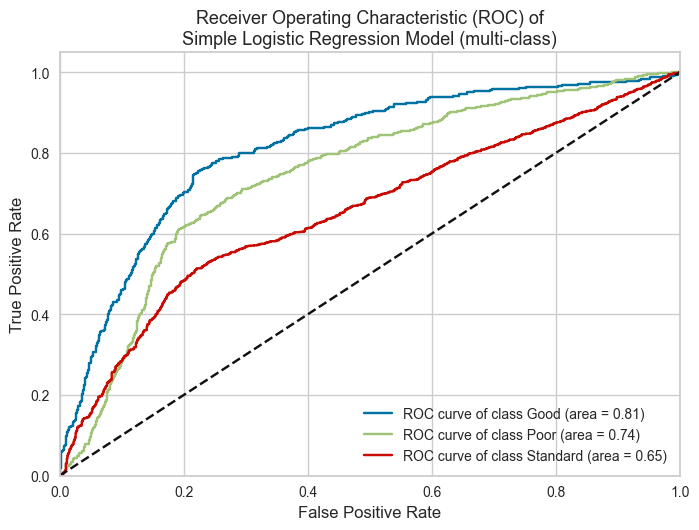

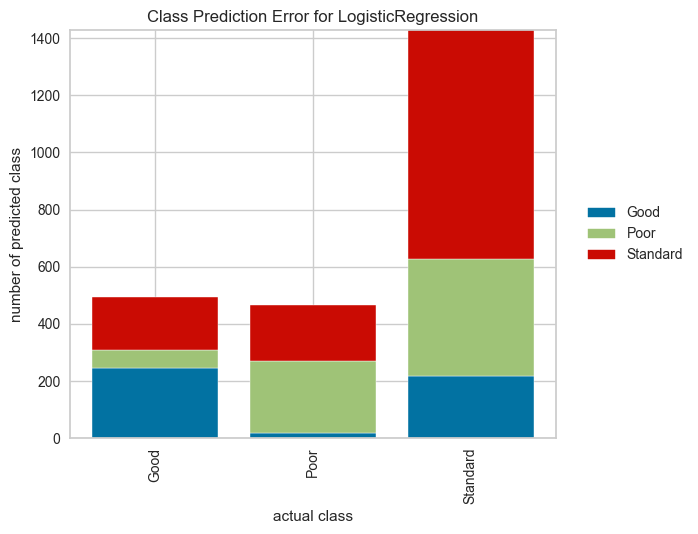

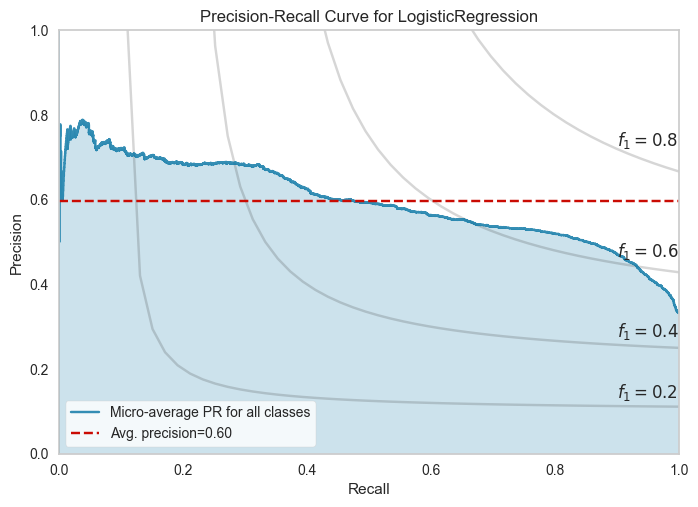

In [27]:
model_lr = \
Pipeline([
    ('preprocessor',pr_oh),
    ('estimator', LogisticRegression(multi_class='multinomial', random_state=42))
])

model_lr.fit(X_train, y_train)


print(classification_report(y_test, model_lr.predict(X_test),
                            target_names=target_names))

auc_scores_simple_lr = multiclass_roc_auc_score_and_plot(model_lr, X_test, y_test, model_name='Simple Logistic Regression')

class_prediction_error_plot(X_train, y_train, X_test, y_test,
                            estimator = model_lr,
                            is_fitted = True);



precision_recall_curve_plot(X_train, y_train, X_test, y_test,
                            estimator = model_lr,
                            line_per_class = False,
                            is_fitted = False,
                            plot_f1_curves=True,);

Below I create a pipeline with a **simple KNN Classifier**:

              precision    recall  f1-score   support

        Good       0.50      0.51      0.50       483
        Poor       0.57      0.53      0.55       720
    Standard       0.63      0.66      0.65      1297

    accuracy                           0.59      2500
   macro avg       0.57      0.56      0.57      2500
weighted avg       0.59      0.59      0.59      2500


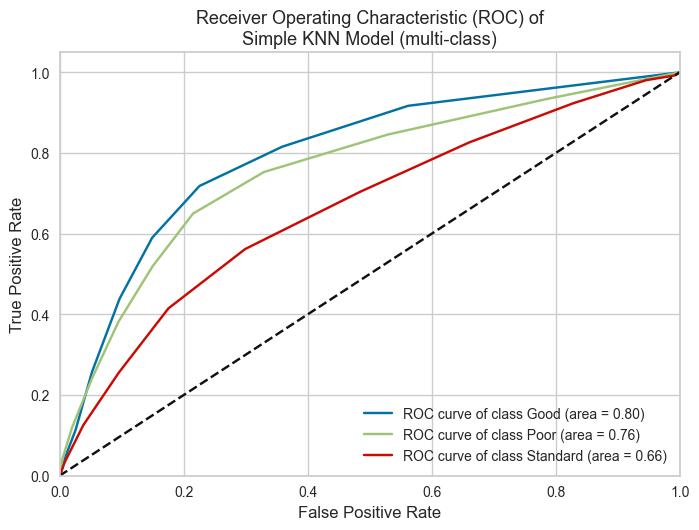

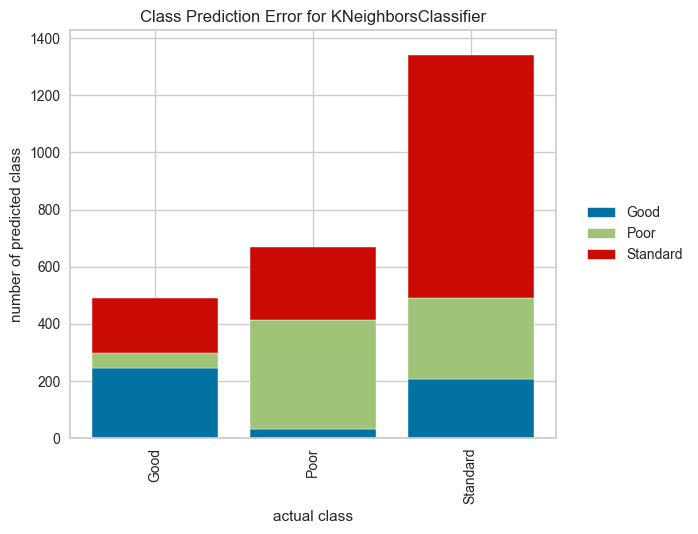

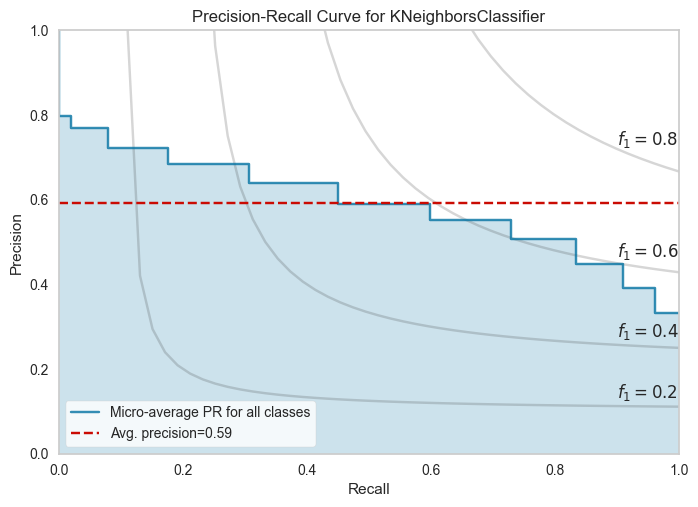

In [28]:
model_knn = \
    Pipeline([
        ('preprocessor',pr_oh),
        ('estimator', KNeighborsClassifier(n_neighbors=10))
    ])

model_knn.fit(X_train, y_train)


print(classification_report(y_test, model_knn.predict(X_test),
                            target_names=target_names))

auc_scores_simple_knn = multiclass_roc_auc_score_and_plot(model_knn, X_test, y_test, model_name='Simple KNN')


class_prediction_error_plot(X_train, y_train, X_test, y_test,
                            estimator = model_knn,
                            is_fitted = True);



precision_recall_curve_plot(X_train, y_train, X_test, y_test,
                            estimator = model_knn,
                            line_per_class = False,
                            is_fitted = False,
                            plot_f1_curves=True,);

Below I create a pipeline with a **simple Decision Tree Classifier**:

              precision    recall  f1-score   support

        Good       0.38      0.40      0.39       483
        Poor       0.46      0.45      0.45       720
    Standard       0.58      0.57      0.57      1297

    accuracy                           0.50      2500
   macro avg       0.47      0.47      0.47      2500
weighted avg       0.50      0.50      0.50      2500


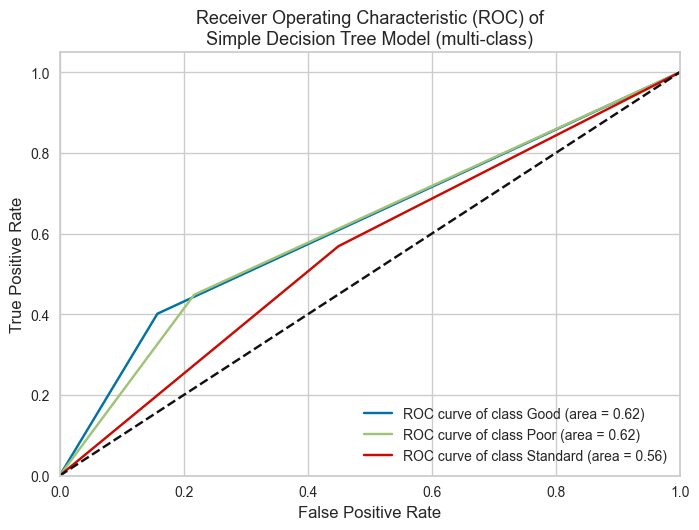

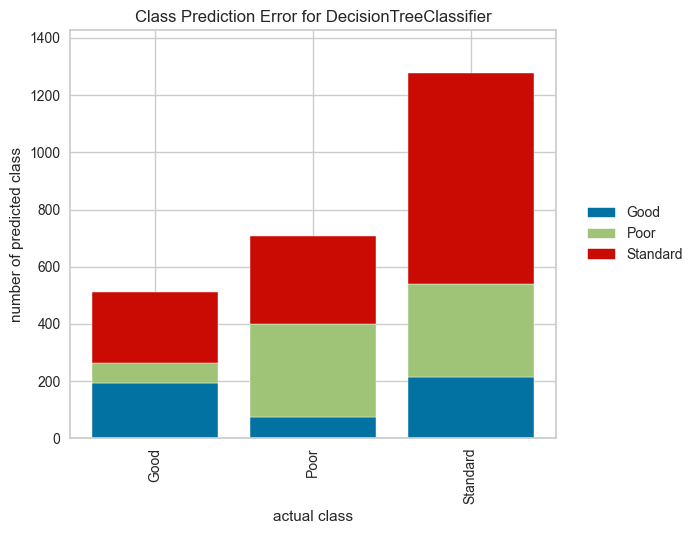

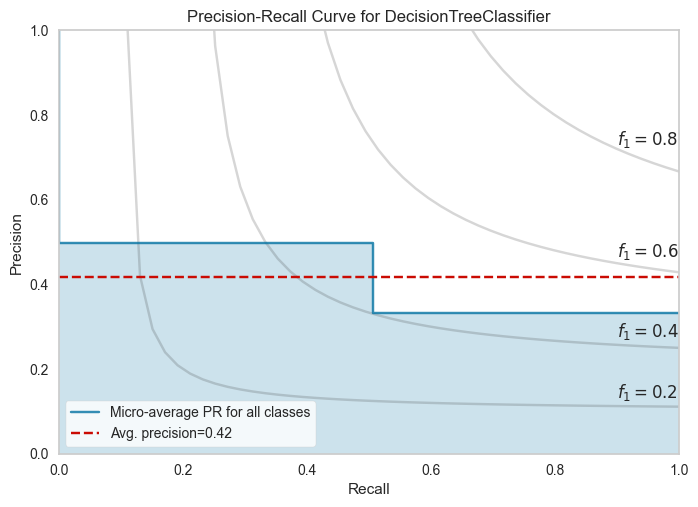

In [29]:
model_dtr = \
    Pipeline([
        ('preprocessor',pr_ord),
        ('estimator', DecisionTreeClassifier(random_state=42))
    ])

model_dtr.fit(X_train, y_train)


print(classification_report(y_test, model_dtr.predict(X_test),
                            target_names=target_names))

auc_scores_simple_dtr = multiclass_roc_auc_score_and_plot(model_dtr, X_test, y_test, model_name='Simple Decision Tree')


class_prediction_error_plot(X_train, y_train, X_test, y_test,
                            estimator = model_dtr,
                            is_fitted = True);



precision_recall_curve_plot(X_train, y_train, X_test, y_test,
                            estimator = model_dtr,
                            line_per_class = False,
                            is_fitted = False,
                            plot_f1_curves=True,);

Below I create a pipeline with a **simple SVM Classifier**:
**Important Note**: For SVM Classifiers I will keep the maximum threshold iterations to 10000.

              precision    recall  f1-score   support

        Good       0.48      0.62      0.54       483
        Poor       0.61      0.56      0.59       720
    Standard       0.67      0.63      0.65      1297

    accuracy                           0.61      2500
   macro avg       0.59      0.60      0.59      2500
weighted avg       0.62      0.61      0.61      2500


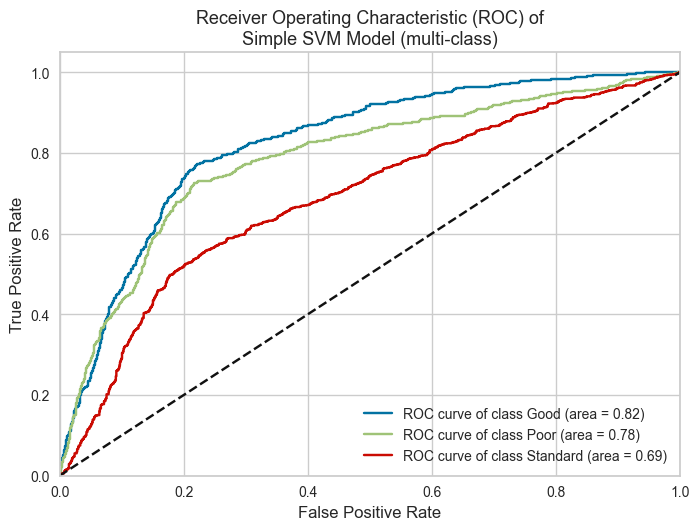

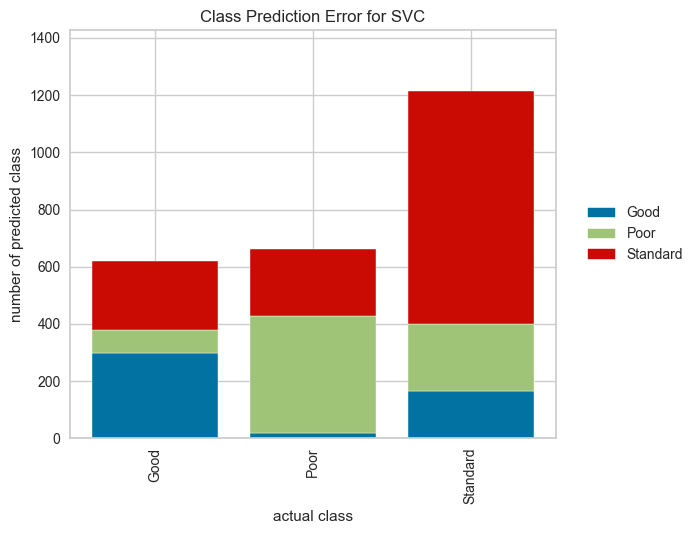

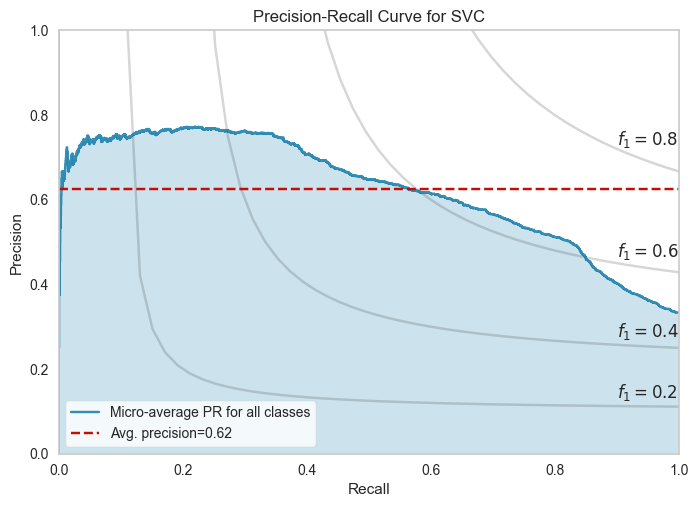

In [30]:
model_svm = \
    Pipeline([
        ('preprocessor',pr_oh),
        ('estimator', SVC(random_state= 42,
                          probability= True,
                          coef0= 1,
                          max_iter= 10_000
                         ) )
    ])

model_svm.fit(X_train, y_train)


print(classification_report(y_test, model_svm.predict(X_test),
                            target_names= target_names))

auc_scores_simple_svm = multiclass_roc_auc_score_and_plot(model_svm, X_test, y_test, model_name='Simple SVM')


class_prediction_error_plot(X_train, y_train, X_test, y_test,
                            estimator = model_svm,
                            is_fitted = True);



precision_recall_curve_plot(X_train, y_train, X_test, y_test,
                            estimator = model_svm,
                            line_per_class = False,
                            is_fitted = False,
                            plot_f1_curves=True,);

#### Using GridSearchCV with the above Classifiers

The [**scoring metrics**](https://scikit-learn.org/stable/modules/model_evaluation.html) I can use on **GridSearchCV** are demonstrated below. I will use ROC curves and AUC score to evaluate my initial models. 

**I choose AUC score for the reasons below**:
- AUC score helps us understand how well the model is able to distinguish between classes at different cutoff levels.
- The AUC gives higher value to correctly classified instances. The **higher the AUC**, the **better the model's performance** in distinguishing between classes.
- The AUC is a useful metric for **imbalanced classes**.
- AUC delivers a performance metric which is effectively a rank-based measure of performance, and as such, it isn't sensitive to the scale of predicted probabilities. Whether my classifier delivers probabilities between 0.1 and 0.5, or 0.9 and 1, won't in itself affect the AUC.

Scoring Metrics available


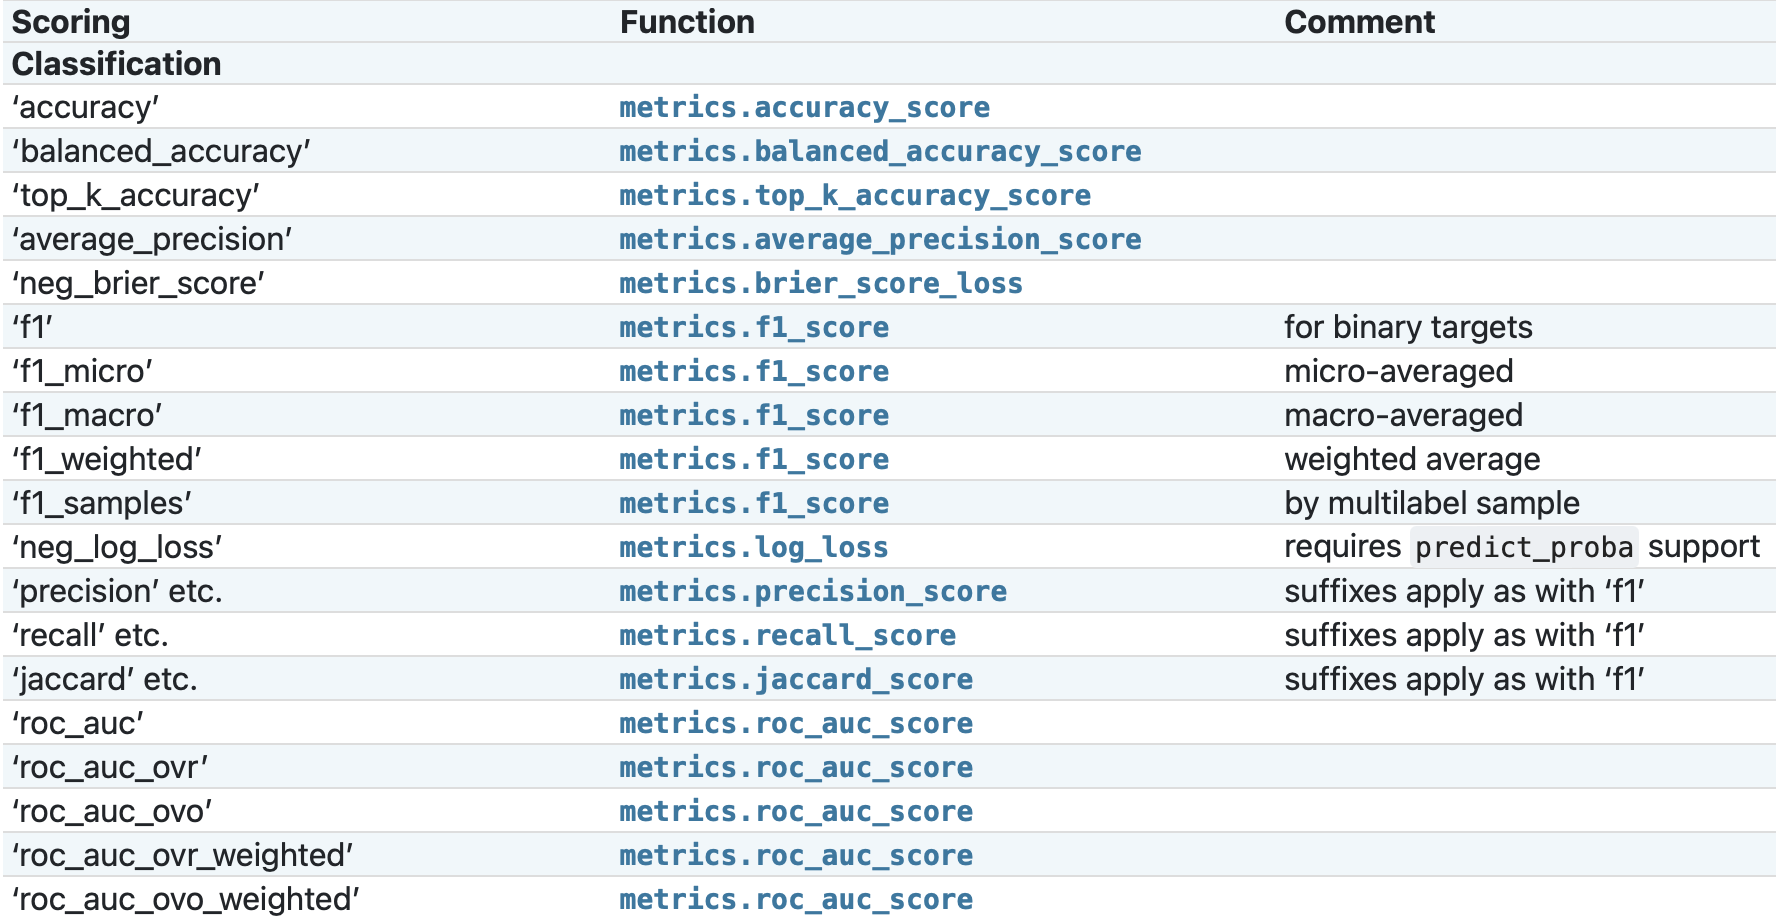

In [31]:
# The score to be used on Grid Searchers:
score_metric_used = 'roc_auc_ovr'

print('Scoring Metrics available')
Image("images/scoring_metrics.png")

Below I use the GridSearchCV on **Logistic Regression** Pipeline:

In [32]:
lr_params = {'estimator__C':[0.1,1,10,100,150,200,250,300,500,1000],
             'estimator__max_iter':[300, 1000, 10000]
             }

grid_lr = \
    GridSearchCV(estimator= model_lr,
                 param_grid= lr_params,
                 scoring= score_metric_used,
                 return_train_score= True
                 ).fit(X_train, y_train)

And I plot/export the metrics below:

              precision    recall  f1-score   support

        Good       0.50      0.51      0.51       483
        Poor       0.54      0.35      0.42       720
    Standard       0.59      0.70      0.64      1297

    accuracy                           0.56      2500
   macro avg       0.54      0.52      0.52      2500
weighted avg       0.56      0.56      0.55      2500


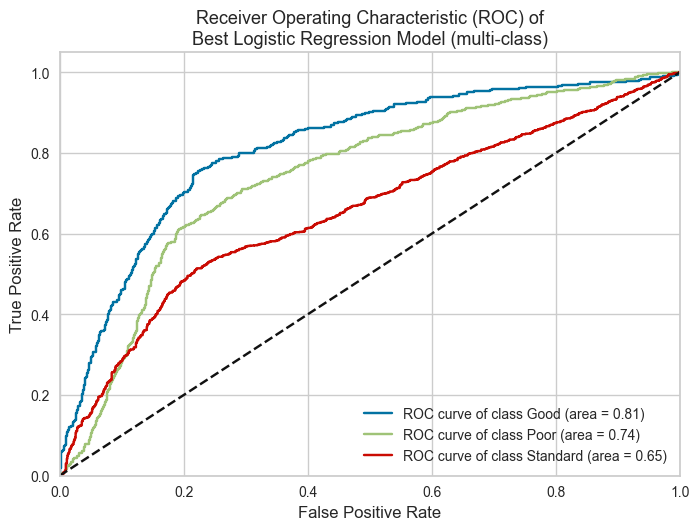

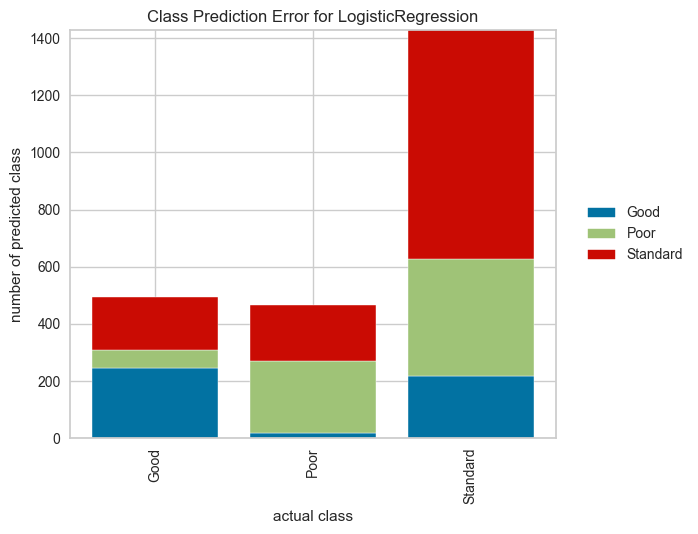

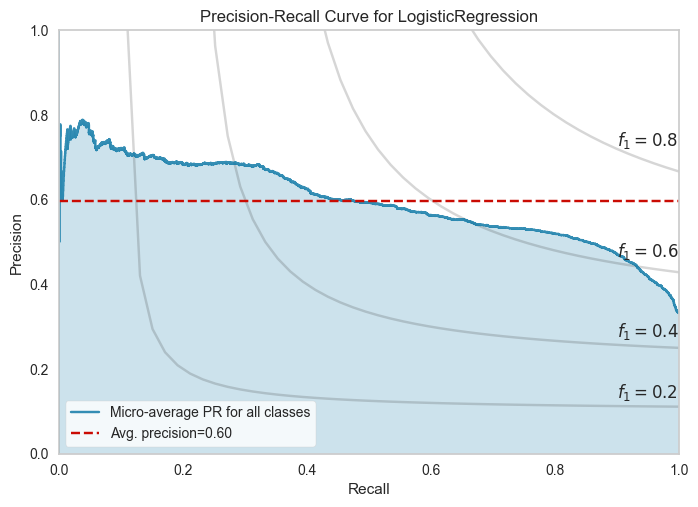

In [33]:
print(classification_report(y_test,
                            grid_lr.best_estimator_.predict(X_test),
                            target_names=target_names)
      )

auc_scores_lr = multiclass_roc_auc_score_and_plot(grid_lr.best_estimator_,
                                               X_test, y_test,
                                               model_name='Best Logistic Regression')

class_prediction_error_plot(X_train, y_train, X_test, y_test,
                            estimator = grid_lr.best_estimator_,
                            is_fitted = True);

precision_recall_curve_plot(X_train, y_train, X_test, y_test,
                            estimator = grid_lr.best_estimator_,
                            line_per_class = False,
                            is_fitted = False,
                            plot_f1_curves=True,);

Below I use the GridSearchCV on **KNN** Pipeline:

**Note**: [Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.distance_metrics.html#sklearn.metrics.pairwise.distance_metrics) of available metrics to check.

In [34]:
knn_params = {'estimator__n_neighbors':[3, 5, 7, 19],
             'estimator__weights':['uniform', 'distance'],
              'estimator__metric':['minkowski','euclidean','manhattan','cosine']
             }

grid_knn = \
    GridSearchCV(estimator= model_knn,
                 param_grid= knn_params,
                 scoring= score_metric_used,
                 return_train_score= True,
                 n_jobs = 4
                 ).fit(X_train, y_train)

And I plot/export the metrics below:

              precision    recall  f1-score   support

        Good       0.51      0.48      0.50       483
        Poor       0.62      0.51      0.56       720
    Standard       0.64      0.71      0.67      1297

    accuracy                           0.61      2500
   macro avg       0.59      0.57      0.58      2500
weighted avg       0.61      0.61      0.61      2500


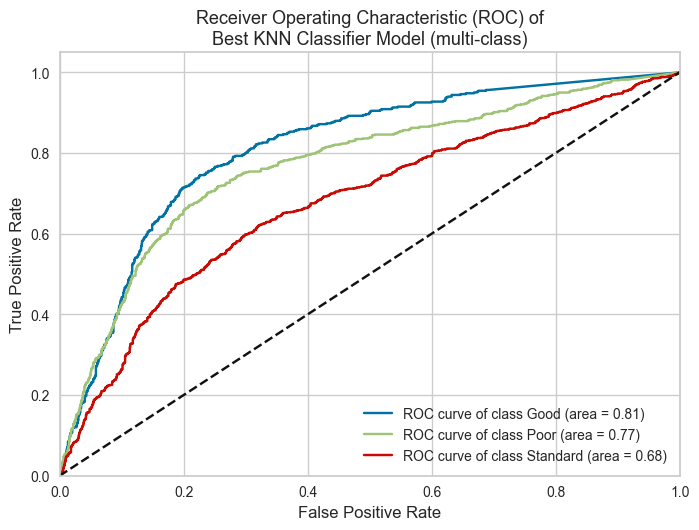

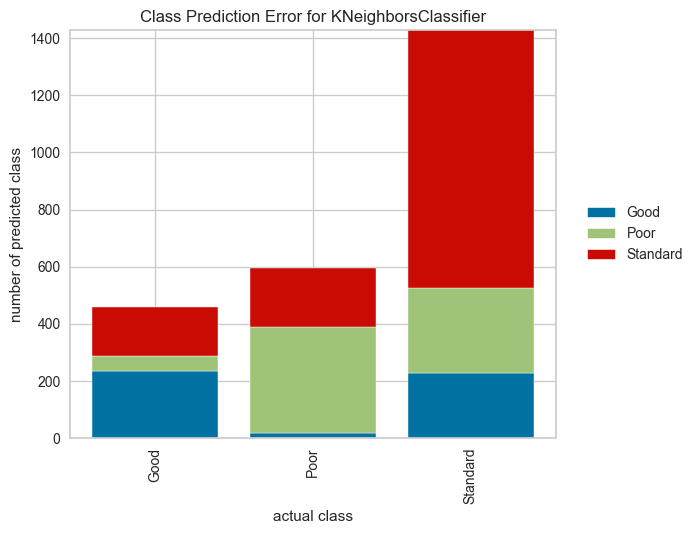

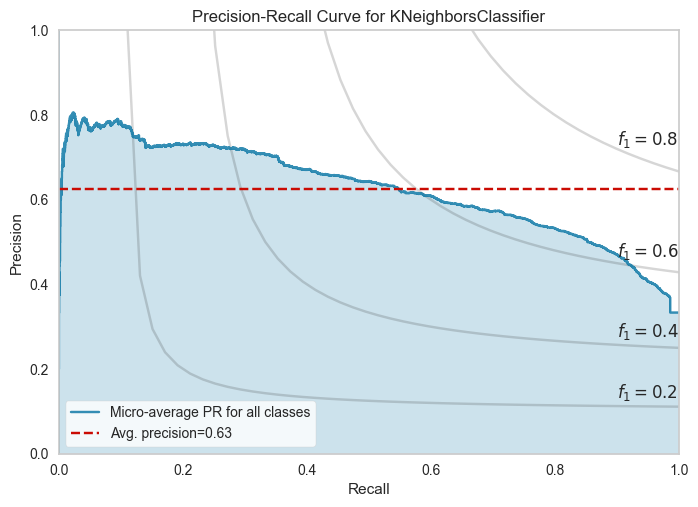

In [35]:
print(classification_report(y_test, grid_knn.best_estimator_.predict(X_test),
                            target_names=target_names)
      )


auc_scores_knn = multiclass_roc_auc_score_and_plot(grid_knn.best_estimator_,
                                               X_test, y_test,
                                               model_name='Best KNN Classifier')


class_prediction_error_plot(X_train, y_train, X_test, y_test,
                            estimator = grid_knn.best_estimator_,
                            is_fitted = True);

precision_recall_curve_plot(X_train, y_train, X_test, y_test,
                            estimator = grid_knn.best_estimator_,
                            line_per_class = False,
                            is_fitted = False,
                            plot_f1_curves=True,);

Below I use the GridSearchCV on **Decision Tree** Pipeline:

In [36]:
dtr_params = {'estimator__criterion':['gini', 'entropy', 'log_loss'],
              'estimator__splitter':['best', 'random'],
              'estimator__min_samples_split':[2,4,6],
              'estimator__min_samples_leaf':[1,2,3,4,5],
              'estimator__max_features':[None, 'sqrt', 'log2'],
              'estimator__max_depth':[None,3, 10, 20 ,30, 100]
              }

grid_dtr = \
    GridSearchCV(estimator= model_dtr,
                 param_grid= dtr_params,
                 scoring= score_metric_used,
                 return_train_score= True,
                 n_jobs = 4
                 ).fit(X_train, y_train)

And I plot/export the metrics below:

              precision    recall  f1-score   support

        Good       0.48      0.68      0.56       483
        Poor       0.61      0.54      0.57       720
    Standard       0.69      0.62      0.65      1297

    accuracy                           0.61      2500
   macro avg       0.59      0.61      0.60      2500
weighted avg       0.62      0.61      0.61      2500


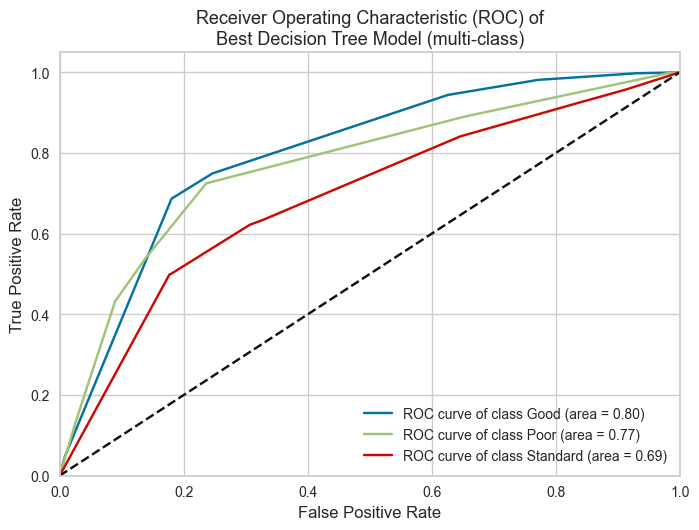

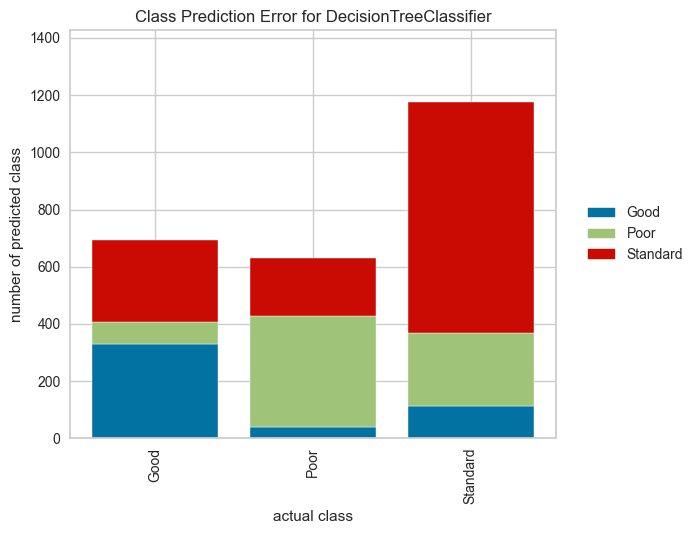

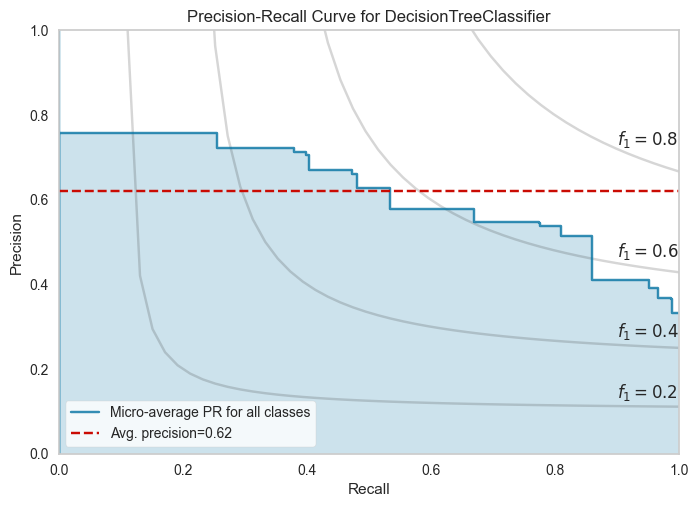

In [37]:
print(classification_report(y_test, grid_dtr.best_estimator_.predict(X_test),
                            target_names=target_names)
      )


auc_scores_dtr = multiclass_roc_auc_score_and_plot(grid_dtr.best_estimator_,
                                               X_test, y_test,
                                               model_name='Best Decision Tree')


class_prediction_error_plot(X_train, y_train, X_test, y_test,
                            estimator = grid_dtr.best_estimator_,
                            is_fitted = True);

precision_recall_curve_plot(X_train, y_train, X_test, y_test,
                            estimator = grid_dtr.best_estimator_,
                            line_per_class = False,
                            is_fitted = False,
                            plot_f1_curves=True,);


Below I use the GridSearchCV on **SVM** Pipeline:

In [ ]:
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)

svm_params = {'estimator__C':[1, 10, 100],
              'estimator__kernel':['rbf', 'linear', 'poly', 'sigmoid'],
              'estimator__gamma':['scale','auto'],
              'estimator__class_weight':[None, 'balanced']
              }

grid_svm = \
    GridSearchCV(estimator= model_svm,
                 param_grid= svm_params,
                 scoring= score_metric_used,
                 return_train_score= True,
                 cv = 2, # because of computational restrictions on my local machine I set the cv = 2
                 n_jobs = 4
                 ).fit(X_train, y_train)

# Produces warnings because of max_iter =  10_000. 
# Unfortunately, I cannot change this setting due to computational constraints of my local machine.

And I plot/export the metrics below:

              precision    recall  f1-score   support

        Good       0.47      0.75      0.58       483
        Poor       0.58      0.70      0.63       720
    Standard       0.75      0.50      0.60      1297

    accuracy                           0.60      2500
   macro avg       0.60      0.65      0.60      2500
weighted avg       0.65      0.60      0.60      2500


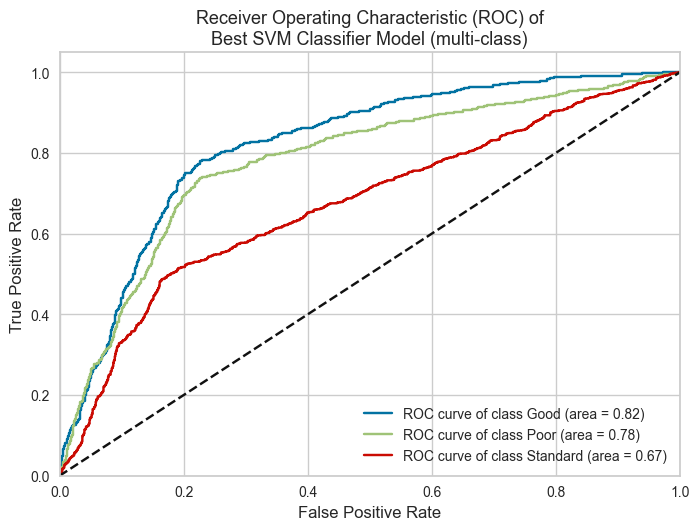

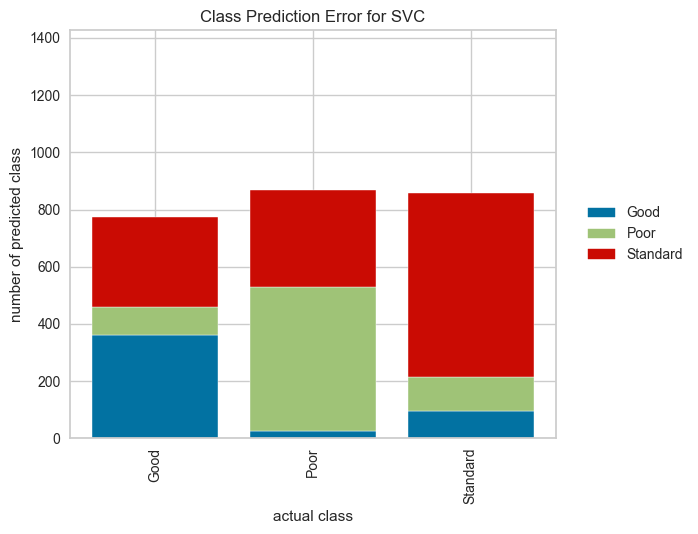

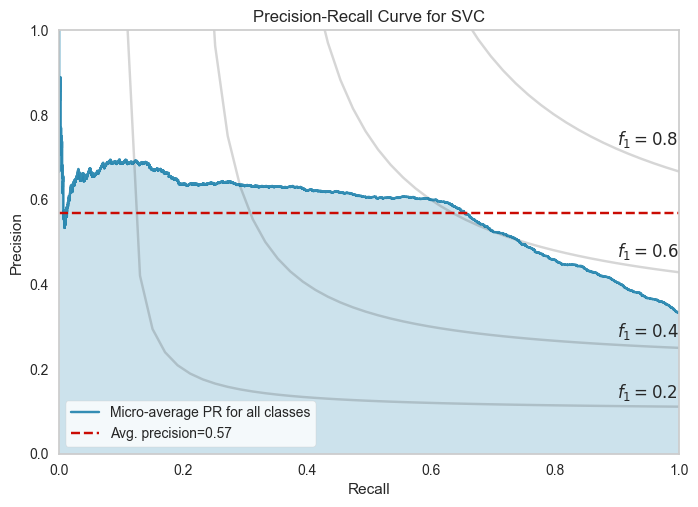

In [39]:
print(classification_report(y_test, grid_svm.best_estimator_.predict(X_test),
                            target_names=target_names)
      )


auc_scores_svm = multiclass_roc_auc_score_and_plot(grid_svm.best_estimator_,
                                                   X_test, y_test,
                                                   model_name='Best SVM Classifier')


class_prediction_error_plot(X_train, y_train, X_test, y_test,
                            estimator = grid_svm.best_estimator_,
                            is_fitted = True);

precision_recall_curve_plot(X_train, y_train, X_test, y_test,
                            estimator = grid_svm.best_estimator_,
                            line_per_class = False,
                            is_fitted = False,
                            plot_f1_curves=True,);

### Additional Models

I add some extra models to the analysis. More specifically, I will use:
- **Random Forest Classifier**
- **Gradient Boosting Classifier**

In [56]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

Below, I create a pipeline with a **simple Random Forest Classifier**:

              precision    recall  f1-score   support

        Good       0.50      0.48      0.49       483
        Poor       0.60      0.57      0.59       720
    Standard       0.64      0.67      0.65      1297

    accuracy                           0.60      2500
   macro avg       0.58      0.57      0.58      2500
weighted avg       0.60      0.60      0.60      2500


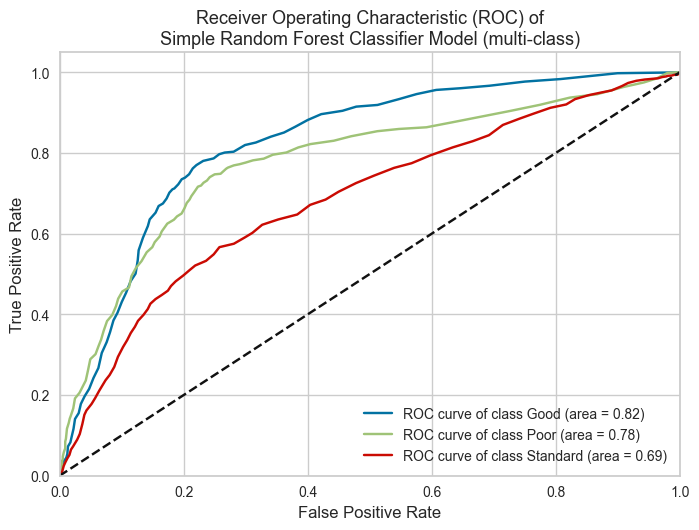

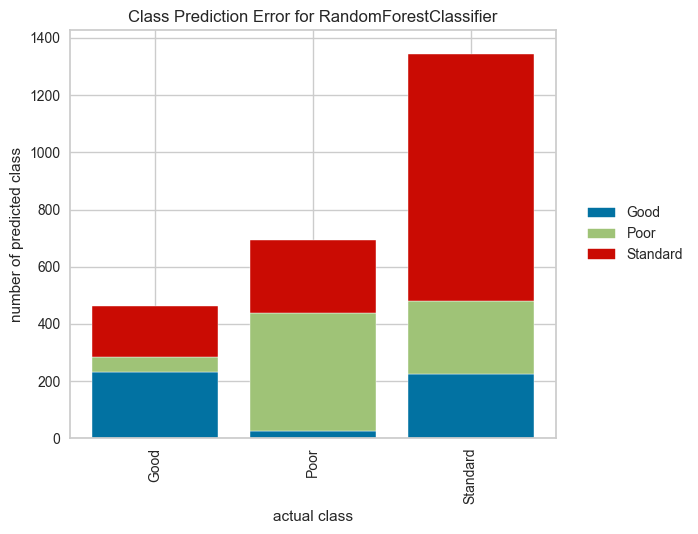

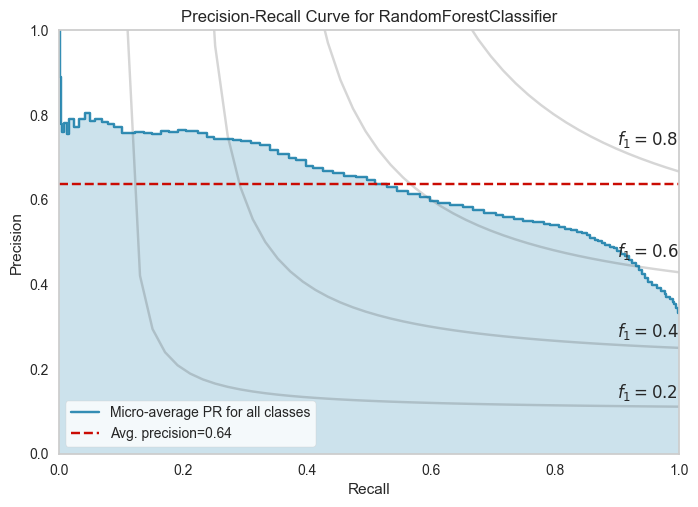

In [60]:
model_ranf = \
    Pipeline([
        ('preprocessor',pr_ord), # it uses tree models, so I do not use One Hot Encoding
        ('estimator', RandomForestClassifier(random_state= 42, oob_score = False) )
    ])

model_ranf.fit(X_train, y_train)


print(classification_report(y_test, model_ranf.predict(X_test),
                            target_names= target_names))

auc_scores_simple_ranf = multiclass_roc_auc_score_and_plot(model_ranf,
                                                           X_test, y_test,
                                                           model_name='Simple Random Forest Classifier')


class_prediction_error_plot(X_train, y_train, X_test, y_test,
                            estimator = model_ranf,
                            is_fitted = True);



precision_recall_curve_plot(X_train, y_train, X_test, y_test,
                            estimator = model_ranf,
                            line_per_class = False,
                            is_fitted = False,
                            plot_f1_curves=True,);

Below, I create a pipeline with a **simple Gradient Boosting Classifier**:

              precision    recall  f1-score   support

        Good       0.51      0.53      0.52       483
        Poor       0.61      0.58      0.60       720
    Standard       0.66      0.67      0.66      1297

    accuracy                           0.62      2500
   macro avg       0.59      0.59      0.59      2500
weighted avg       0.62      0.62      0.62      2500


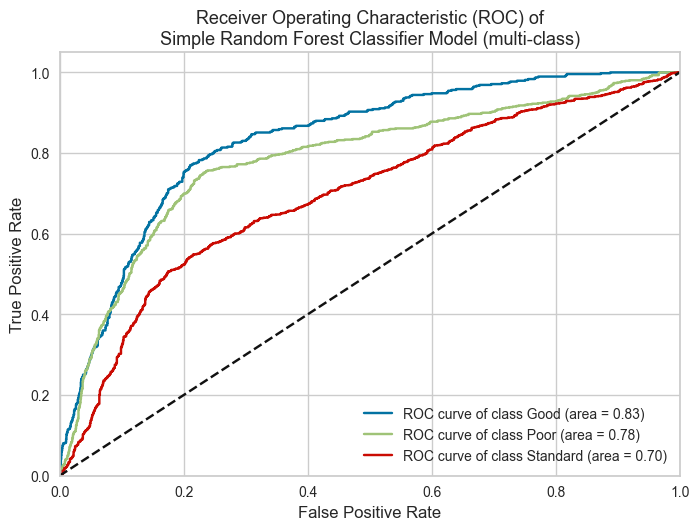

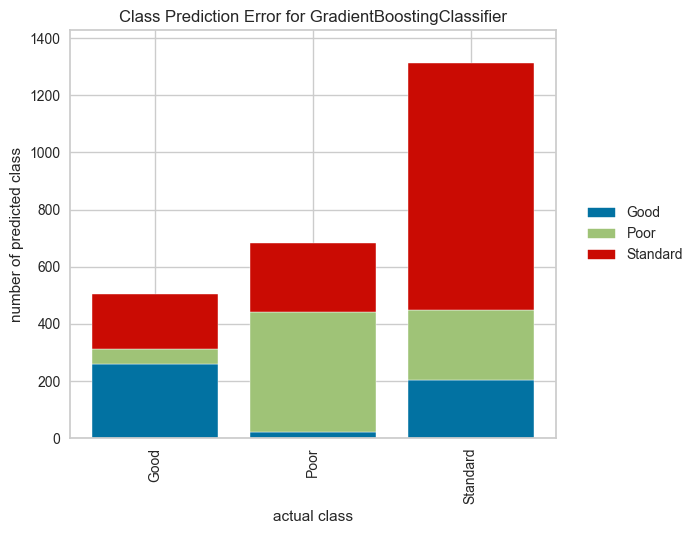

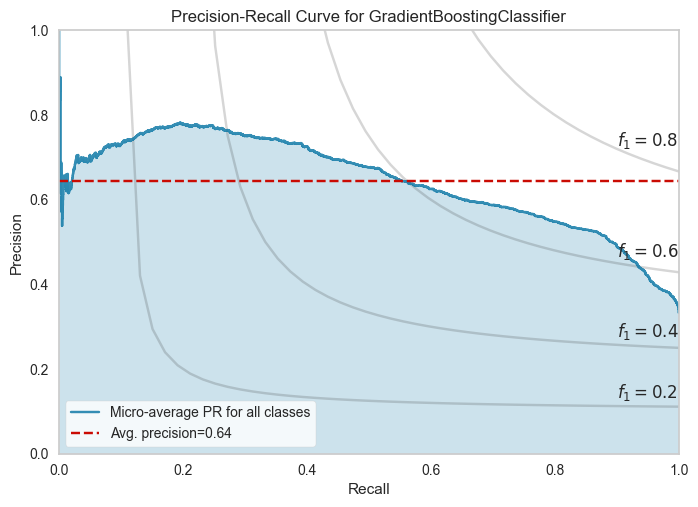

In [57]:
model_gbc = \
    Pipeline([
        ('preprocessor',pr_ord), # it uses tree models, so I do not use One Hot Encoding
        ('estimator', GradientBoostingClassifier(random_state= 42) )
    ])

model_gbc.fit(X_train, y_train)


print(classification_report(y_test, model_gbc.predict(X_test),
                            target_names= target_names))

auc_scores_simple_gbc = multiclass_roc_auc_score_and_plot(model_gbc,
                                                          X_test, y_test,
                                                          model_name= 'Simple Gradient Boosting Classifier')


class_prediction_error_plot(X_train, y_train, X_test, y_test,
                            estimator = model_gbc,
                            is_fitted = True);



precision_recall_curve_plot(X_train, y_train, X_test, y_test,
                            estimator = model_gbc,
                            line_per_class = False,
                            is_fitted = False,
                            plot_f1_curves=True,);

#### Using GridSearchCV on the above models

Below I use the GridSearchCV on **Random Forest Classifier** Pipeline:

In [65]:
ranf_params = {'estimator__n_estimators':[1, 10, 100],
              'estimator__criterion':['gini', 'entropy'],
              #'estimator__ccp_alpha': [0.0, 0.05, 0.2], # commented to reduce the dimensions of param_grid
              'estimator__max_features':[None, 'sqrt', 'log2'],
              'estimator__max_depth':[3, 10, 20]
              }

grid_ranf = \
    GridSearchCV(estimator= model_ranf,
                 param_grid= ranf_params,
                 scoring= score_metric_used,
                 return_train_score= True,
                 n_jobs = 4
                 ).fit(X_train, y_train)

And I plot/export the metrics below:

              precision    recall  f1-score   support

        Good       0.51      0.63      0.56       483
        Poor       0.62      0.59      0.60       720
    Standard       0.69      0.64      0.66      1297

    accuracy                           0.62      2500
   macro avg       0.60      0.62      0.61      2500
weighted avg       0.63      0.62      0.63      2500


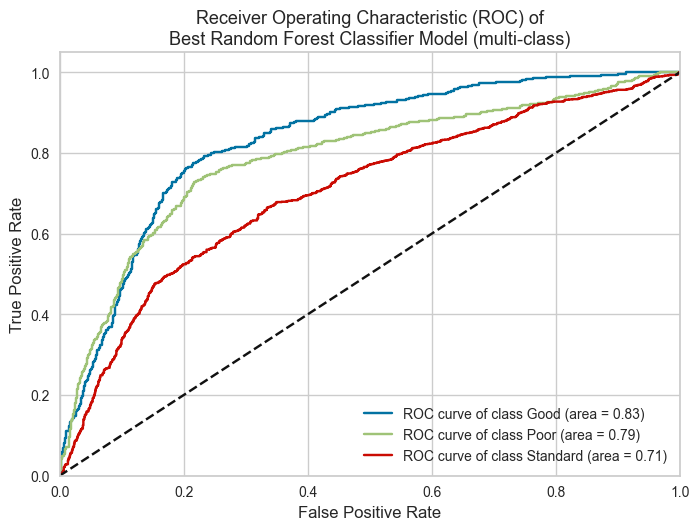

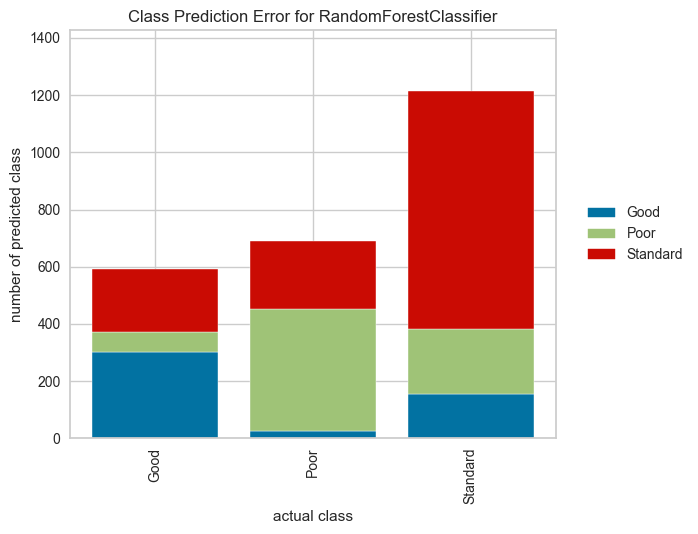

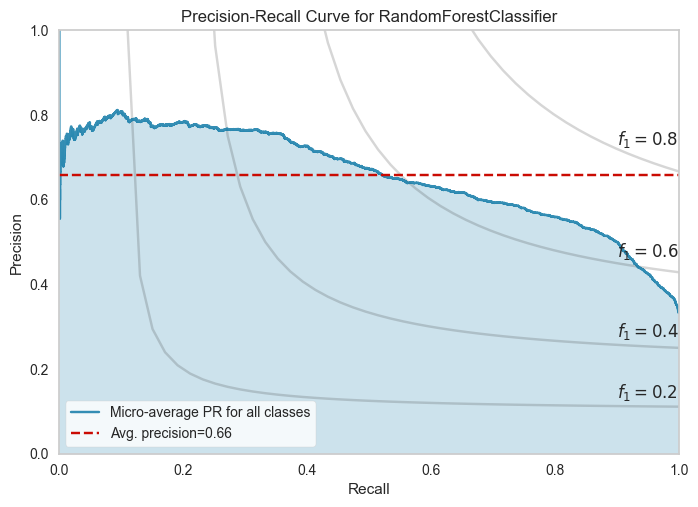

In [66]:
print(classification_report(y_test, grid_ranf.best_estimator_.predict(X_test),
                            target_names=target_names)
      )


auc_scores_ranf = multiclass_roc_auc_score_and_plot(grid_ranf.best_estimator_,
                                                   X_test, y_test,
                                                   model_name='Best Random Forest Classifier')


class_prediction_error_plot(X_train, y_train, X_test, y_test,
                            estimator = grid_ranf.best_estimator_,
                            is_fitted = True);

precision_recall_curve_plot(X_train, y_train, X_test, y_test,
                            estimator = grid_ranf.best_estimator_,
                            line_per_class = False,
                            is_fitted = False,
                            plot_f1_curves=True,);

Below I use the GridSearchCV on **Gradient Boosting Classifier** Pipeline:

In [68]:
gbc_params = {'estimator__learning_rate':[0.1, 1],
               'estimator__n_estimators':[10, 100],
               'estimator__criterion':['friedman_mse', 'squared_error'], # commented to reduce the dimensions of param_grid
               'estimator__ccp_alpha': [0.0, 0.05, 0.2],
               'estimator__max_features':['sqrt', 'log2'],
               'estimator__max_depth':[3, 10, 20]
               }

grid_gbc = \
    GridSearchCV(estimator= model_gbc,
                 param_grid= gbc_params,
                 scoring= score_metric_used,
                 return_train_score= True,
                 n_jobs = 4
                 ).fit(X_train, y_train)

And I plot/export the metrics below:

              precision    recall  f1-score   support

        Good       0.51      0.52      0.52       483
        Poor       0.62      0.57      0.60       720
    Standard       0.65      0.68      0.66      1297

    accuracy                           0.62      2500
   macro avg       0.60      0.59      0.59      2500
weighted avg       0.62      0.62      0.62      2500


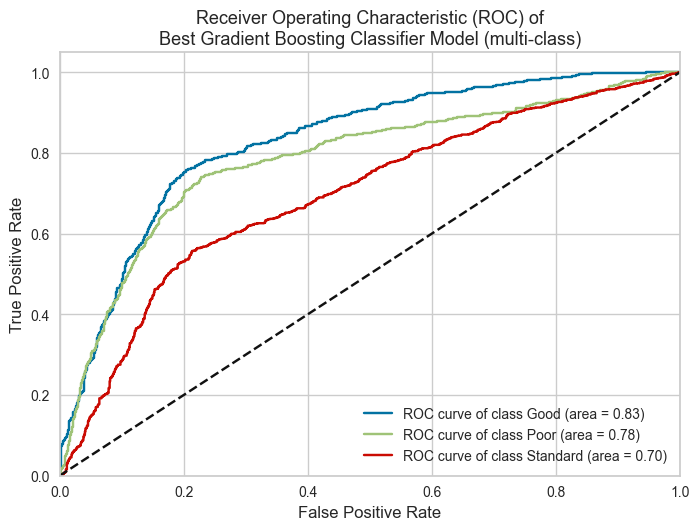

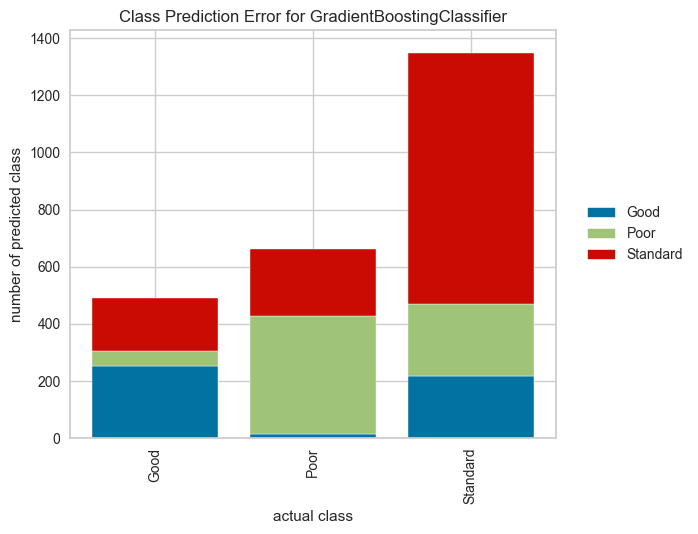

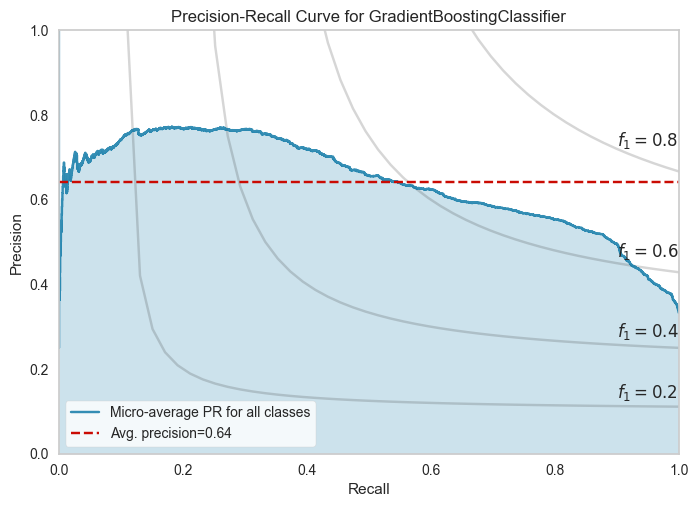

In [69]:
print(classification_report(y_test, grid_gbc.best_estimator_.predict(X_test),
                            target_names=target_names)
      )


auc_scores_gbc = multiclass_roc_auc_score_and_plot(grid_gbc.best_estimator_,
                                                    X_test, y_test,
                                                    model_name='Best Gradient Boosting Classifier')


class_prediction_error_plot(X_train, y_train, X_test, y_test,
                            estimator = grid_gbc.best_estimator_,
                            is_fitted = True);

precision_recall_curve_plot(X_train, y_train, X_test, y_test,
                            estimator = grid_gbc.best_estimator_,
                            line_per_class = False,
                            is_fitted = False,
                            plot_f1_curves=True,);